# Import libraries

In [6]:
# General libraries
import numpy as np
from pyDOE import lhs

# Simulation libraries
import skysurvey
import skysurvey_sniapop
import ztfidr.simulation as sim

# Parallelisation libraries
from joblib import Parallel, delayed

# Module functions
import ximinf.selection_effect as se

# Plot libraries
import matplotlib.pyplot as plt

# Generation of SN Ia samples in parallel

In [ ]:
# -------- User parameters --------

N = 100_000 # Number of samples
M = 100 # Number of SNe per sample

# Range of standardisation paremeters
alpha_range = (-2,6) # TO CHANGE FOR TWO PARAMS FOR BROKEN ALPHA #(-0.6, 0.4)
beta_range  = (-2, 6) #(2.8, 3.8)
mabs_range = (-19.8, -18.8) #(-19.8, -18.8)

# ---------------------------------

# Sampling
unit_samples = lhs(3, samples=N) #(3, samples=N)
alpha_vals = unit_samples[:, 0] * (alpha_range[1] - alpha_range[0]) + alpha_range[0]
beta_vals  = unit_samples[:, 1] * (beta_range[1]  - beta_range[0])  + beta_range[0]
mabs_vals  = unit_samples[:, 2] * (mabs_range[1]  - mabs_range[0])  + mabs_range[0]

# Simulation function
def simulate_one(i, α, β, mabs):
    # Print progress
    if (i+1) % (N//10) == 0 or i == N-1:  # also print on last iteration
        print(f"Simulation {i+1}/{N}", end="\r", flush=True)

    brokenalpha_model = skysurvey_sniapop.brokenalpha_model

    # Model the SNe Ia
    snia = skysurvey.SNeIa.from_draw(
        size=M,
        zmax=0.2,
        model=brokenalpha_model,
        magabs={
            "x1": "@x1",
            "c": "@c",
            #"mabs": float(mabs),
            "sigmaint": 0.0, #0.15
            "alpha_low": float(α),
            "alpha_high": float(α),
            "beta":  float(β),
        }
    )

    # Apply realistic noise
    errormodel = sim.noise_model
    errormodel.pop("localcolor", None)
    noisy_snia = snia.apply_gaussian_noise(errormodel)

    # Create dataframe with only needed columns
    df = noisy_snia.data[["z", "magobs", "x1", "c"]]
    magobs = df["magobs"].to_numpy(dtype=np.float32)
    x1     = df["x1"].to_numpy(dtype=np.float32)
    c      = df["c"].to_numpy(dtype=np.float32)
    z      = df["z"].to_numpy(dtype=np.float32)

    # Reshape dataframe into a 1D numpy array containing the relevant data
    flat = np.concatenate([magobs, x1, c, z])
    flat_with_params = np.concatenate([[α, β, mabs], flat]).astype(np.float32)
    return i, flat_with_params

# Parallel execution
print("Launching parallel simulations...")
results = Parallel(n_jobs=6)(
    delayed(simulate_one)(i, α, β, mabs) for i, (α, β, mabs) in enumerate(zip(alpha_vals, beta_vals, mabs_vals))
)
print("... simulations done")

# Collect results
simulations = np.empty((N, 4 * M + 3), dtype=np.float32)
for i, flat in results:
    simulations[i, :] = flat

# # Applying selection effect
# print('Applying selection effect...')
# m_lim = 22
# simulations = se.malmquist_bias_batch(simulations, m_lim, M)
# print('...done')

Launching parallel simulations...


# Plot the first sample

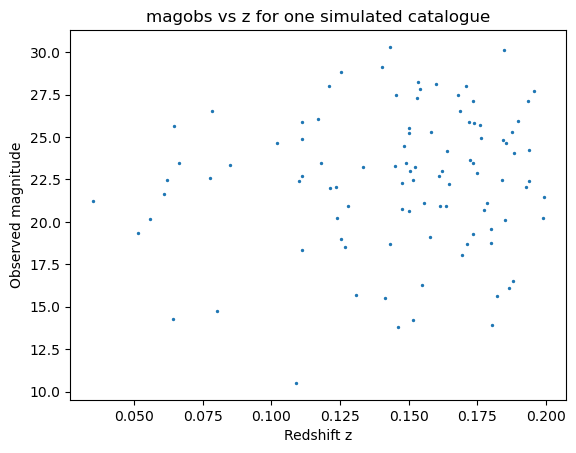

In [ ]:
example = simulations[0]

# parse flattened catalogue
magobs = example[3 : 3 + M]
x1     = example[3 + M : 3 + 2*M]
c      = example[3 + 2*M : 3 + 3*M]
z      = example[3 + 3*M : 3 + 4*M]

# remove padded zeros (non-detections)
mask = magobs != 0
magobs_sel = magobs[mask]
z_sel = z[mask]

plt.figure()
plt.scatter(z_sel, magobs_sel, s=2)
plt.xlabel("Redshift z")
plt.ylabel("Observed magnitude")
plt.title("magobs vs z for one simulated catalogue")
plt.show()

# Save data to disk

In [ ]:
print("Save results ...")
np.save("../data/SIM/simulations.npy", simulations)
size_bytes = N * (4*M+3) * np.dtype(simulations.dtype).itemsize
size_MB = size_bytes / (1024**2)
print(f"... saved {size_MB:.2f} MB to 'simulations.npy'")

Save results ...
... saved 153.73 MB to 'simulations.npy'
